In [1]:
import numpy as np
import h5py
import glob
from PIL import Image
import matplotlib.pyplot as plt


In [2]:
h5_path = 'Datasets/training/images_90_ratio.h5'
groundtruth_images_path = 'Datasets/training/groundtruth'
satelite_images_path = 'Datasets/training/images'

In [3]:




satelite_images = list(map(Image.open, glob.glob(satelite_images_path + '/*.png')))
groundtruth_images = list(map(Image.open, glob.glob(groundtruth_images_path + '/*.png')))

train_test_ratio = 0.8

train_images = satelite_images[0:int(train_test_ratio*len(satelite_images))]
train_groundtruth = groundtruth_images[0:int(train_test_ratio*len(groundtruth_images))]

test_images = satelite_images[int(train_test_ratio*len(satelite_images)):]
test_groundtruth = groundtruth_images[int(train_test_ratio*len(groundtruth_images)):]

train_shape = (len(train_images), 400, 400, 3)
train_groundtruth_shape = (len(train_images),400, 400)

test_shape = (len(test_images), 400, 400, 3)
test_groundtruth_shape = (len(test_images),400, 400)



In [4]:
def add_to_h5(h5file, name_of_group, group, convertion):
    
    for i in range(len(group)):
        
        img = group[i]
        img = img.convert(convertion)
        
        img = np.array(img)
        
        if convertion == 'L':
            
            img = img > 10
            img = img.reshape((400,400,1))
        
        img = np.moveaxis(img, 2, 0) # to tensor

        h5file[name_of_group][i, ...] = img[None]
        
def add_to_h5_not_tensor(h5file, name_of_group, group, convertion):
    
    for i in range(len(group)):
        
        img = group[i]
        
        img = img.convert(convertion)
        
        img = np.array(img)

        if convertion == 'L':
            
            img = img > 10
            img = img*255
#             img = img.reshape((400,400,1))

        h5file[name_of_group][i, ...] = img[None]
        
def add_to_h5_normalized(h5file, name_of_group, group, convertion):
    
    for i in range(len(group)):
        
        img = group[i]
        img = img.convert(convertion)
        
        img = np.array(img)
        
        if convertion == 'L':
            
            img = img > 10
            img = img.reshape((400,400,1))
        else:
            # normalize
            img = (img - np.mean(img))/np.std(img)
        
        img = np.moveaxis(img, 2, 0) # to tensor
        h5file[name_of_group][i, ...] = img[None]
        
def add_to_h5_normalized_per_pixel(h5file, name_of_group, group, convertion):
    
    for i in range(len(group)):
        
        img = group[i]
        img = img.convert(convertion)
        
        img = np.array(img)
        
        if convertion == 'L':
            
            img = img > 10
            img = img.reshape((400,400,1))
        else:
            # normalize
            mean = h5file[name_of_group + '_mean'][...]
            std = h5file[name_of_group + '_std'][...]
            img = (img - mean)/std
            
        
        img = np.moveaxis(img, 2, 0) # to tensor
        h5file[name_of_group][i, ...] = img[None]
        
def find_mean_and_std(h5file, means, stds, name_of_group, group):
    # find mean
    mean = np.zeros_like(np.array(group[0].convert('RGB'))).astype(np.float64)
    print()
    for i in range(len(group)):
        
        img = group[i]
        img = img.convert('RGB')
        
        img = np.array(img)
        
        mean = mean + img
        
    mean = mean/len(group)
    
    h5file[means][...] = mean[None]
    
     # find mean
    std = np.zeros_like(np.array(group[0].convert('RGB'))).astype(np.float64)
    
    for i in range(len(group)):
        
        img = group[i]
        img = img.convert('RGB')
        
        img = np.array(img)
        
        std = std + (img - mean)**2
        
    
    std = np.sqrt(std/(len(group) - 1))
    h5file[stds][...] = std[None]
    
def online_mean_and_sd(loader):
    """Compute the mean and sd in an online fashion

        Var[x] = E[X^2] - E^2[X]
    """
    cnt = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)

    for data in loader:

        b, c, h, w = data.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(data, dim=[0, 2, 3])
        sum_of_square = torch.sum(data ** 2, dim=[0, 2, 3])
        fst_moment = (cnt * fst_moment + sum_) / (cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (cnt + nb_pixels)

        cnt += nb_pixels

    return fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)
    
def find_mean_and_std_unique(h5file, means, stds, name_of_group, group):  #taken and adapted from https://discuss.pytorch.org/t/about-normalization-using-pre-trained-vgg16-networks/23560/9
    # find mean
    cnt = 0
    fst_moment = np.empty(3)
    snd_moment = np.empty(3)
    
    for i in range(len(group)):
        
        img = group[i]
        
        img = img.convert('RGB')
        
        img = np.array(img)
        img = np.moveaxis(img, 2, 0).astype(np.float64)
        c, h, w = img.shape
        nb_pixels = h * w       
        sum_ = np.sum(img, axis=(1,2))
        sum_of_square = np.sum(img ** 2, axis=(1,2))
        fst_moment = (cnt * fst_moment + sum_) / (cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (cnt + nb_pixels)
        cnt += nb_pixels
    h5file[means][...] = fst_moment[None]  
    h5file[stds][...] = np.sqrt(snd_moment - fst_moment ** 2)[None]  
    

In [5]:



with h5py.File(h5_path, mode='w') as h5file:
    
    h5file.create_dataset("train", train_shape, np.uint8)
    h5file.create_dataset("train_groundtruth", train_groundtruth_shape, np.uint8)
    h5file.create_dataset("test", test_shape, np.uint8)
    h5file.create_dataset("test_groundtruth", test_groundtruth_shape, np.uint8)
    # for per pixel mean + std
    h5file.create_dataset('train_mean', (1, 3), np.float64)
    h5file.create_dataset('train_std',(1, 3), np.float64)
    h5file.create_dataset('test_mean', (1, 3), np.float64)
    h5file.create_dataset('test_std', (1, 3), np.float64)
    

    
    find_mean_and_std_unique(h5file, 'train_mean', 'train_std', 'train', train_images)
    find_mean_and_std_unique(h5file, 'test_mean', 'test_std', 'test', test_images)
    
    add_to_h5_not_tensor(h5file, 'train', train_images, 'RGB')
    add_to_h5_not_tensor(h5file, 'train_groundtruth', train_groundtruth, 'L')
    add_to_h5_not_tensor(h5file, 'test', test_images, 'RGB')
    add_to_h5_not_tensor(h5file, 'test_groundtruth', test_groundtruth, 'L')



[[84.84693063 83.85345148 74.79218188]]
[[48.77804744 47.22947293 47.31974807]]


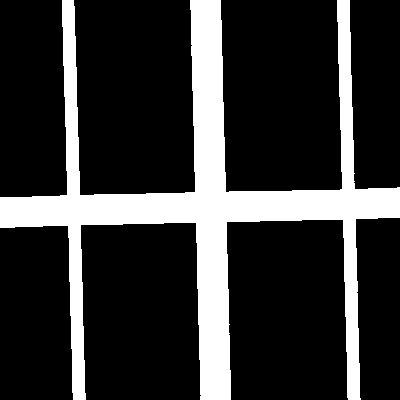

In [6]:
with h5py.File(h5_path, mode='r') as h5file:

    train = h5file['train'][0,...]
    groundtruth = h5file['train_groundtruth'][0,...]
    mean = h5file['train_mean'][...]
    std = h5file['train_std'][...]
print(mean)
print(std)
train = train*std+mean
train = (train).astype("uint8")
groundtruth = (groundtruth).astype("uint8")

groundtruth = groundtruth.reshape((400,400))

train = Image.fromarray(train)
groundtruth = Image.fromarray(groundtruth)

groundtruth





In [7]:
# Get percentage of positives compared to negatives

In [8]:

size_positives = 0
size_total = 0
for i in range(len(groundtruth_images)):
    
    img = groundtruth_images[i]
 
    img = img.convert('L')
    img = np.array(img)
    img = img > 10
    
    size_positives = size_positives + img.sum()
    size_total = size_total + img.shape[0]*img.shape[1]
        
size_positives/size_total

0.2093884375